In [126]:
from qiskit import *
from qiskit.visualization import *
import math
from qiskit.circuit.library import QFT
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
import qiskit

In [127]:
# defining a general Uf gate
def Uf(a,qc,q):
    for i in range(len(a)):
        if a[i]=='0':
            qc.x(q[len(a)-1-i])
            
    qc.mcx(list(range(0,q.size-1)),q[q.size-1])
    
    for i in range(len(a)):
        if a[i]=='0':
            qc.x(q[len(a)-1-i])

In [128]:
# our new "oracle"
def U(qc, q):
    num = ['001','011','101']
    for i in num:
        Uf(i,qc,q)

In [129]:
# defining W
def W(qc,q):
    for i in range(q.size-1):
        qc.h(q[i])
        qc.x(q[i])
        
    qc.h(q[q.size-2])
    qc.mcx(list(range(0,q.size-2)),q[q.size-2])
    qc.h(q[q.size-2])
    
    for i in range(q.size-1):
        qc.x(q[i])
        qc.h(q[i])

In [130]:
# make your custom control gate for Grover operator

def cu(power):
    q=QuantumRegister(n+1)
    test = QuantumCircuit(q)
    
    
    # constructing the Grover operator to a power
    for i in range(2**power):
        U(test, q)
        W(test,q)
        
        
    c_q = test.to_gate().control()
    
    return c_q

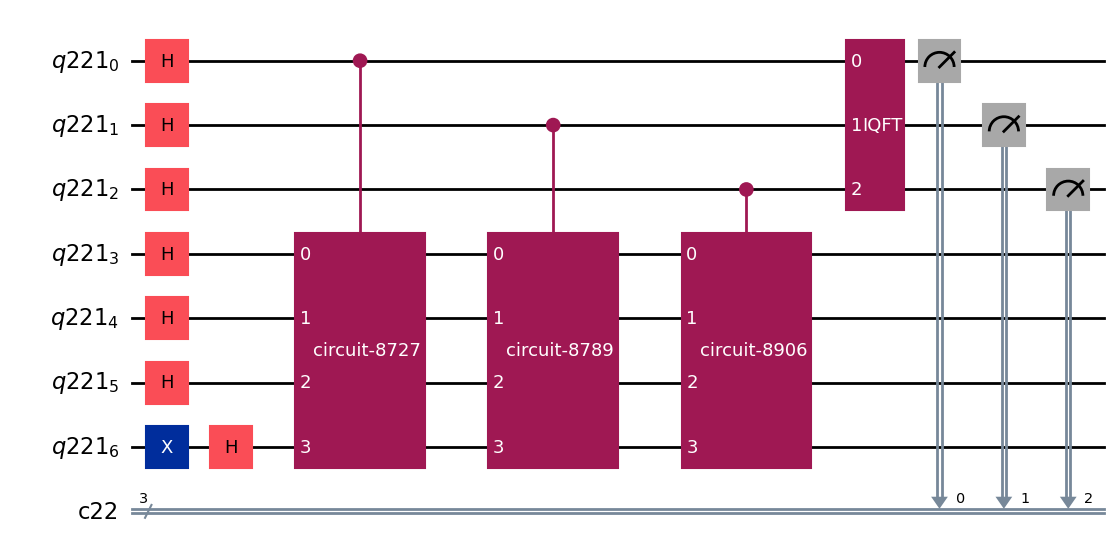

In [131]:
# quantum phase estimation

# number of ancillary qubits only for QPE:
anc = 3 # this is the value of t
n = 3
# making the quantum circuit
q=QuantumRegister(n+anc+1)
creg = ClassicalRegister(anc)
qc = QuantumCircuit(q,creg)

# setting up the eigenvector, which is the initial state of the input register in Grover's search
# setting up the Hadamards on the ancillay qubits in QPE
qc.x(q[q.size-1])
qc.h(q[0:q.size])


t = creg.size   

# adding the control gates
for i in range(t):
    index_list = [i]
    index_list+=list(range(t,q.size))
    qc.append(cu(i),index_list)
          
# inverse quantum fourier transform
qc.append(QFT(t).inverse(), q[0:t])
          
qc.measure(q[0:t],creg)

qc.draw(output="mpl") # draw out the quantum circuit for QPE

In [132]:
# Results from running QPE
# Import section
from qiskit_aer import AerSimulator
from qiskit import transpile
# For execution
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
sim_result = simulator.run(compiled_circuit, shot=1024)
result = sim_result.result()
counts1 = result.get_counts(qc)
print(counts1)
# Gets the most frequent value from counts1, which is the j that QPE returns
freq = qiskit.result.Counts.most_frequent(counts1)
qpe_result = int(freq,2)

{'110': 365, '101': 93, '111': 31, '010': 352, '100': 28, '001': 36, '011': 102, '000': 17}


In [133]:
# jumlah elemen yang ditandai
m = 2**(n) * (math.cos(math.pi * (qpe_result) / 2**(t)))**2
print(m)

3.999999999999999


1.1107207345395915


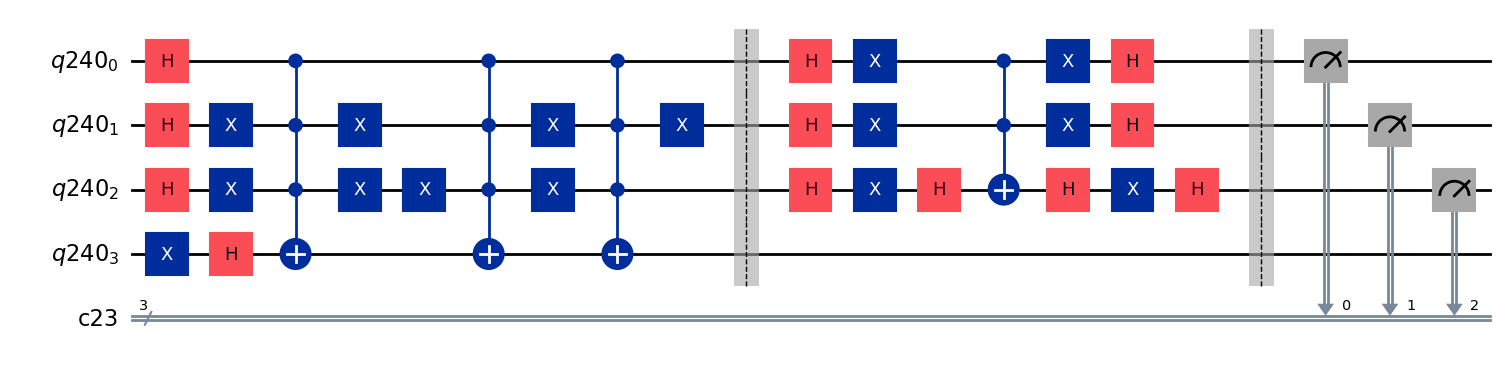

In [134]:
# Grover search!
qreg1=QuantumRegister(n+1)
creg1 = ClassicalRegister(n)
qcircuit = QuantumCircuit(qreg1,creg1)
#initialize the one state in the y
qcircuit.x(qreg1[qreg1.size-1])
#put all the qubits in superposition
qcircuit.h(qreg1)

# number of k iterations
iterations = math.pi/4*math.sqrt(2**(n)/m)
print (iterations)

for i in range(round(iterations)):
    U(qcircuit, qreg1)
    qcircuit.barrier()
    W(qcircuit, qreg1)
    qcircuit.barrier()
    
qcircuit.measure(qreg1[0:qreg1.size-1],creg1)
qcircuit.draw(output="mpl") # draw the quantum circuit

{'011': 287, '101': 299, '010': 35, '001': 275, '110': 34, '000': 33, '100': 33, '111': 28}


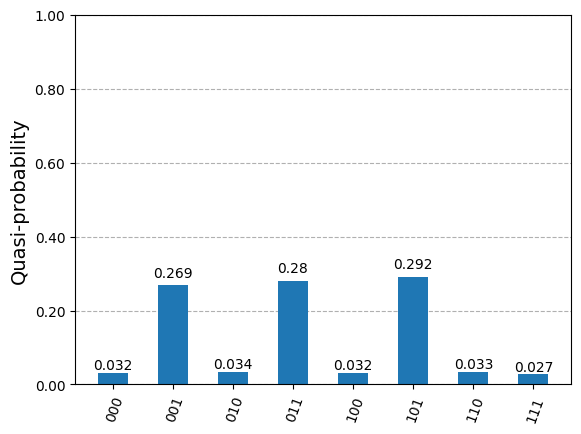

In [135]:
# Import section
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# For execution
simulator = AerSimulator()
compiled_circuit = transpile(qcircuit, simulator)
sim_result = simulator.run(compiled_circuit, shots=1024)
result = sim_result.result()
counts = result.get_counts(qcircuit)
print(counts)
fig, ax = plt.subplots()
plot_distribution(counts, ax=ax)
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()
